# Project : Emotion Detection With FER 2013

loading the Librarires

In [2]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline


haars cascade is loaded into the notebook

In [4]:
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')

use this function to detect face


In [6]:
def detect_face(img):
    face_img = img.copy()
  
    face_rects = face_cascade.detectMultiScale(face_img, minNeighbors=1) 
    
    for (x,y,w,h) in face_rects: 
        cv2.rectangle(face_img, (x,y), (x+w,y+h), (255,255,255), 10) 
        
    return face_img
    

reading an Image

In [8]:
def turn_to_gray(im_path):
    image = cv2.imread(im_path) 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray


In [9]:
from pathlib import Path

root = Path("D:/University/Massey University/2nD year Sem 2/Big Data Processing and Applied Machine Learning/Assignment 03/data/train/angry")

image_names = ["Training_63181.jpg","Training_9402163.jpg","Training_99531165.jpg","Training_81730099.jpg", "Training_8861363.jpg"]
image_paths = []

for item in image_names:
    image_path = root / item  
    image_paths.append(image_path)

print(image_paths)


[WindowsPath('D:/University/Massey University/2nD year Sem 2/Big Data Processing and Applied Machine Learning/Assignment 03/data/train/angry/Training_63181.jpg'), WindowsPath('D:/University/Massey University/2nD year Sem 2/Big Data Processing and Applied Machine Learning/Assignment 03/data/train/angry/Training_9402163.jpg'), WindowsPath('D:/University/Massey University/2nD year Sem 2/Big Data Processing and Applied Machine Learning/Assignment 03/data/train/angry/Training_99531165.jpg'), WindowsPath('D:/University/Massey University/2nD year Sem 2/Big Data Processing and Applied Machine Learning/Assignment 03/data/train/angry/Training_81730099.jpg'), WindowsPath('D:/University/Massey University/2nD year Sem 2/Big Data Processing and Applied Machine Learning/Assignment 03/data/train/angry/Training_8861363.jpg')]


visualizing it 

In [11]:
detections = []
for item in image_paths:
    gray = turn_to_gray(item)
    det = detect_face(gray)
    detections.append(det)

calling the detect function

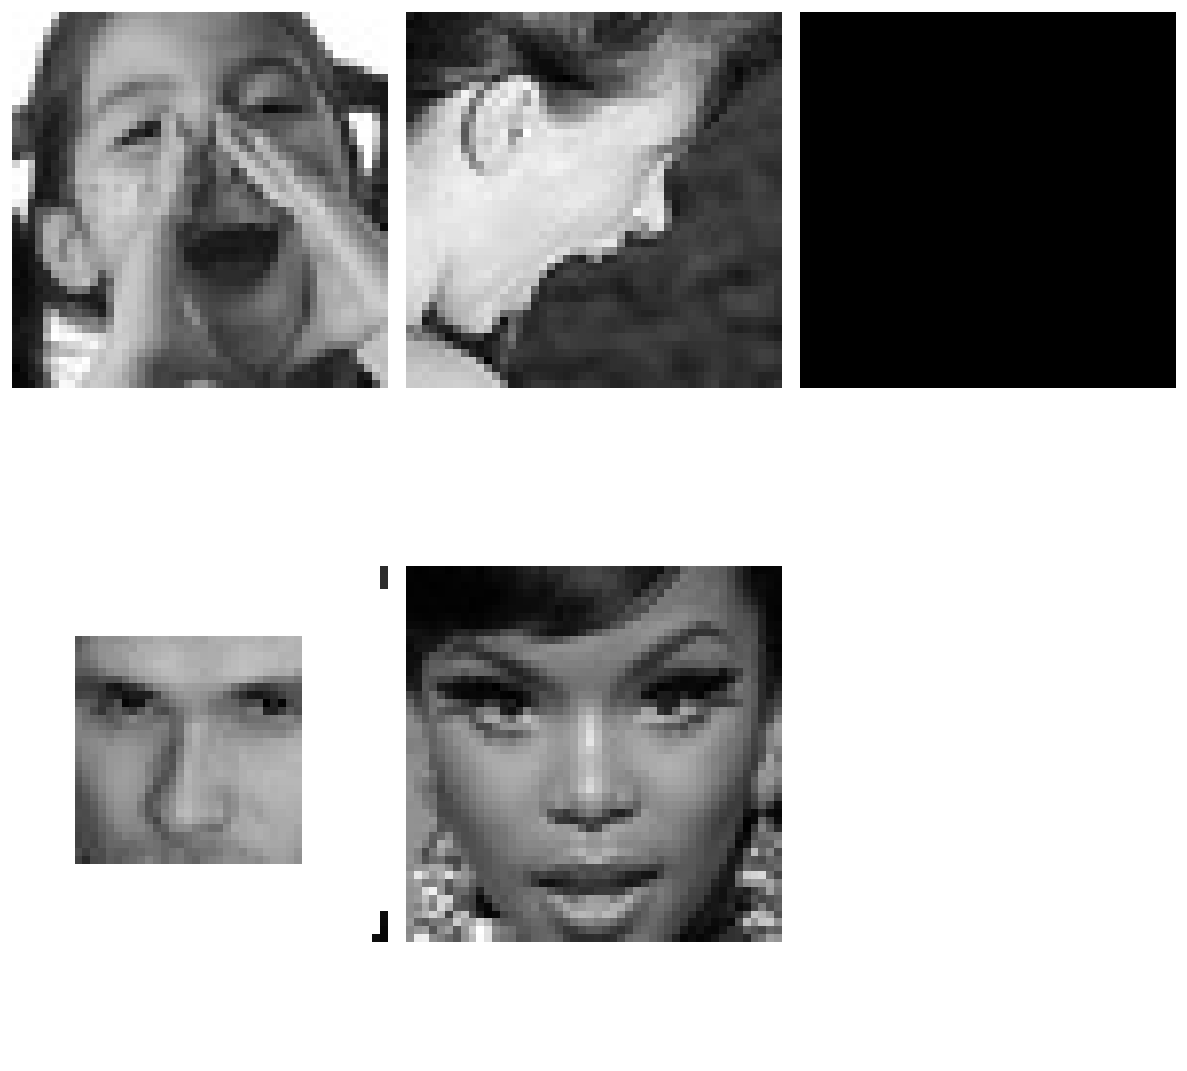

In [281]:
import matplotlib.pyplot as plt

# assume detections is a list of 48x48 arrays (dtype=uint8)
num_images = len(detections)
cols = 3  # number of columns
rows = (num_images + cols - 1) // cols  # auto-calculate rows

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for ax, img in zip(axes.flat, detections):
    ax.imshow(img, cmap='gray')
    ax.axis('off')

# hide any extra subplots (if detections not perfectly divisible by cols)
for ax in axes.flat[len(detections):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


Out of all the images chosen only one was detected as a face, first image with the girl covering her face and the second image with the man who has his face turned and the black image are all bad data, however thw woman in the final image is good data , but the haars cascade hasn't detected this properly. 

However, the fourth image has been detected properly

Use this function to crop the images

In [15]:
def crop_bbox(img, x, y, w, h, pad=0):
    H, W = img.shape[:2]
    x1 = max(0, x - pad)
    y1 = max(0, y - pad)
    x2 = min(W, x + w + pad)
    y2 = min(H, y + h + pad)
    return img[y1:y2, x1:x2]

In [16]:
def detect_face(img, minN):
    face_img = img.copy()
  
    face_rects = face_cascade.detectMultiScale(face_img, minNeighbors=minN) 
    
    for (x,y,w,h) in face_rects: 
        cv2.rectangle(face_img, (x,y), (x+w,y+h), (255,255,255), 10) 
        
    return face_rects

In [17]:
def detect_faces_robust(img_bgr,scaleFactor=1.08, minNeighbors=1, minSize=(18,18),clahe=True, upsample_if_small=True):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    if clahe:
        gray = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4)).apply(gray)
    scale_back = 1.0
    if upsample_if_small and (gray.shape[0] < 200 or gray.shape[1] < 200):
        gray = cv2.resize(gray, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_CUBIC)
        scale_back = 0.5
    faces = face_cascade.detectMultiScale(gray, scaleFactor=scaleFactor, minNeighbors=minNeighbors,minSize=minSize, flags=cv2.CASCADE_SCALE_IMAGE)

    boxes = []
    for (x,y,w,h) in faces:
        if scale_back != 1.0:
            x = int(x*scale_back); y = int(y*scale_back)
            w = int(w*scale_back); h = int(h*scale_back)
        boxes.append((x,y,w,h))
    return boxes

In [53]:
import os,csv
from tqdm import tqdm

def filter_dataset_with_haar(in_root, out_root,resize_to=(48,48), pad=4, keep_largest_only=True,  
    save_rejects=True, rejects_subdir="_rejects", force_grayscale=True, write_manifest=True):
    in_root  = Path(in_root)
    out_root = Path(out_root)
    out_root.mkdir(parents=True, exist_ok=True)
    rej_root = out_root / rejects_subdir    
    if save_rejects:
        rej_root.mkdir(parents=True, exist_ok=True)

    kept, rejected = 0, 0

    exts = {".jpg",".jpeg",".png",".bmp",".webp"}
    img_paths = [p for p in in_root.rglob("*") if p.suffix.lower() in exts]
    for p in tqdm(img_paths, desc="Filtering"):
        
        rel = p.relative_to(in_root)
        label = rel.parent.name 
        img = cv2.imread(str(p))
        if img is None: 
            rejected += 1
            continue
        boxes = detect_faces_robust(img)  
        if not boxes:
            rejected += 1
            if save_rejects:
                (rej_root/label).mkdir(parents=True, exist_ok=True)
                cv2.imwrite(str((rej_root/label/f"{p.stem}_noface{p.suffix}")), img)
            continue
        sel = boxes
        if keep_largest_only:
            sel = [max(boxes, key=lambda b: b[2]*b[3])]
        dst_dir = out_root/label
        dst_dir.mkdir(parents=True, exist_ok=True)
        for i,(x,y,w_,h_) in enumerate(sel):
            crop = crop_bbox(img, x,y,w_,h_, pad=pad)
            if resize_to:
                crop = cv2.resize(crop, resize_to, interpolation=cv2.INTER_AREA)
            if force_grayscale:
                crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY) 
            fname = f"{p.stem}_face{i}.png"
            out_path = dst_dir/fname
            cv2.imwrite(str(out_path), crop)
            kept += 1
    print(f"Done. Kept: {kept}  |  Rejected: {rejected}  |  Output -> {out_root}")


In [55]:
filter_dataset_with_haar(in_root = r"data/train", out_root = r"new_data/train")

Filtering: 100%|█████████████████████████████████████████████████████████████████| 28709/28709 [07:10<00:00, 66.75it/s]

Done. Kept: 19734  |  Rejected: 8975  |  Output -> new_data\train


In [56]:
filter_dataset_with_haar(in_root = r"data/test", out_root = r"new_data/test")

Filtering: 100%|███████████████████████████████████████████████████████████████████| 7178/7178 [01:50<00:00, 65.19it/s]

Done. Kept: 4893  |  Rejected: 2285  |  Output -> new_data\test


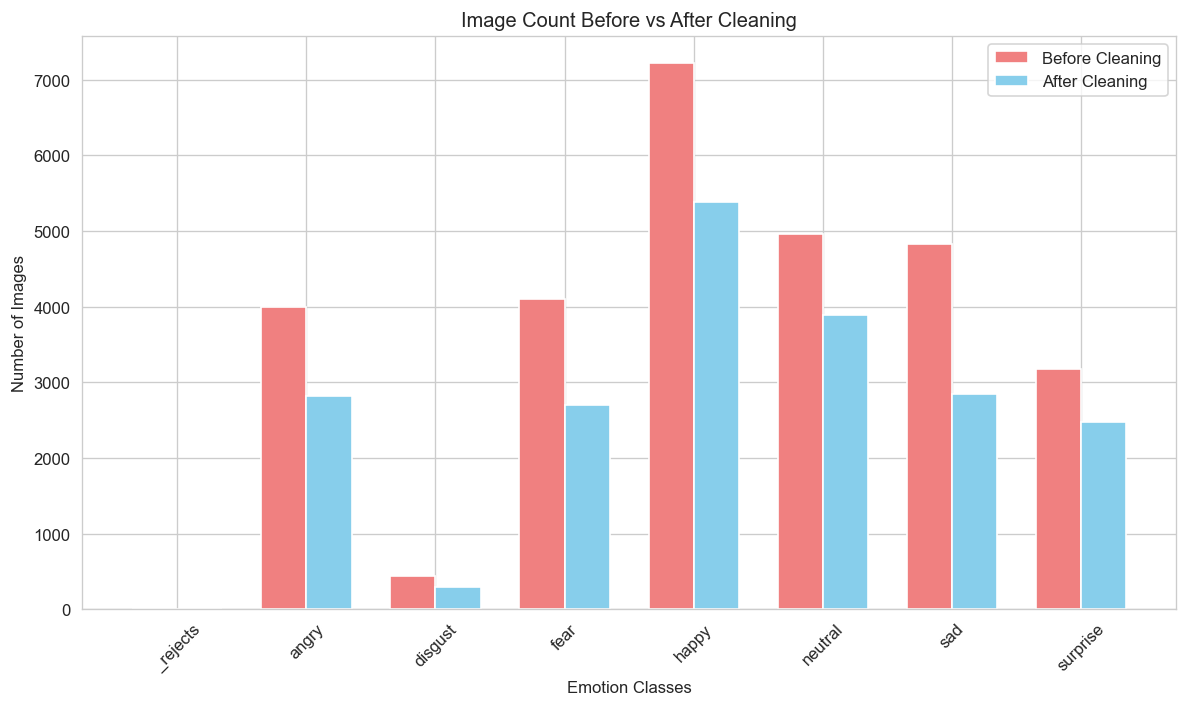

In [289]:
import os
import matplotlib.pyplot as plt
import numpy as np

# --- Define base paths ---
before_path = r"D:\University\Massey University\2nd year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\data\train"
after_path  = r"D:\University\Massey University\2nd year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\new_data\train"

def count_images(base_path):
    folder_counts = {}
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        if os.path.isdir(folder_path):
            count = len([
                f for f in os.listdir(folder_path)
                if os.path.isfile(os.path.join(folder_path, f))
            ])
            folder_counts[folder] = count
    return folder_counts

# --- Count images before and after cleaning ---
before_counts = count_images(before_path)
after_counts  = count_images(after_path)

# --- Ensure both have the same folder order ---
all_classes = sorted(set(before_counts.keys()) | set(after_counts.keys()))
before_values = [before_counts.get(c, 0) for c in all_classes]
after_values  = [after_counts.get(c, 0) for c in all_classes]

# --- Create double bar chart ---
x = np.arange(len(all_classes))  # positions
width = 0.35  # bar width

plt.figure(figsize=(10,6))
plt.bar(x - width/2, before_values, width, label='Before Cleaning', color='lightcoral')
plt.bar(x + width/2, after_values,  width, label='After Cleaning', color='skyblue')

plt.xlabel("Emotion Classes")
plt.ylabel("Number of Images")
plt.title("Image Count Before vs After Cleaning")
plt.xticks(x, all_classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


it seems that almost one third of the data has been deleted with the haars cascade it might make it harder for our machine learning models to pick up the patterns in the data . another data foltering method should be used 

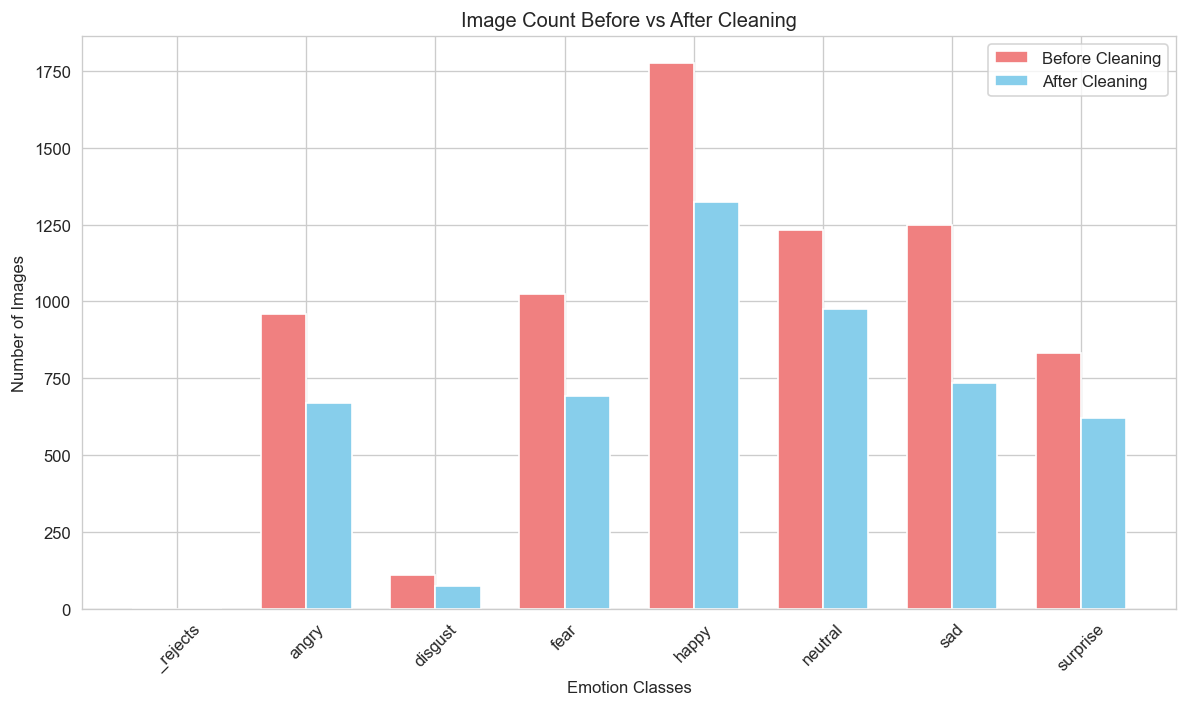

In [291]:
import os
import matplotlib.pyplot as plt
import numpy as np

# --- Define base paths ---
before_path = r"D:\University\Massey University\2nd year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\data\test"
after_path  = r"D:\University\Massey University\2nd year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\new_data\test"

def count_images(base_path):
    folder_counts = {}
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        if os.path.isdir(folder_path):
            count = len([
                f for f in os.listdir(folder_path)
                if os.path.isfile(os.path.join(folder_path, f))
            ])
            folder_counts[folder] = count
    return folder_counts

# --- Count images before and after cleaning ---
before_counts = count_images(before_path)
after_counts  = count_images(after_path)

# --- Ensure both have the same folder order ---
all_classes = sorted(set(before_counts.keys()) | set(after_counts.keys()))
before_values = [before_counts.get(c, 0) for c in all_classes]
after_values  = [after_counts.get(c, 0) for c in all_classes]

# --- Create double bar chart ---
x = np.arange(len(all_classes))  # positions
width = 0.35  # bar width

plt.figure(figsize=(10,6))
plt.bar(x - width/2, before_values, width, label='Before Cleaning', color='lightcoral')
plt.bar(x + width/2, after_values,  width, label='After Cleaning', color='skyblue')

plt.xlabel("Emotion Classes")
plt.ylabel("Number of Images")
plt.title("Image Count Before vs After Cleaning")
plt.xticks(x, all_classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Almost one third of the test data has also been deleted. 

Using a mtcnn model to clean the data

In [370]:
from mtcnn.mtcnn import MTCNN

img_path = image_paths[-1] 
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(img_path)

rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

detector = MTCNN()
results = detector.detect_faces(rgb)

for r in results:
    x, y, w, h = r["box"]
    cv2.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 2)
    for (lx, ly) in r["keypoints"].values():
        cv2.circle(img, (lx, ly), 3, (0,0,255), -1)

print(f"Found {len(results)} face(s)")



Found 1 face(s)


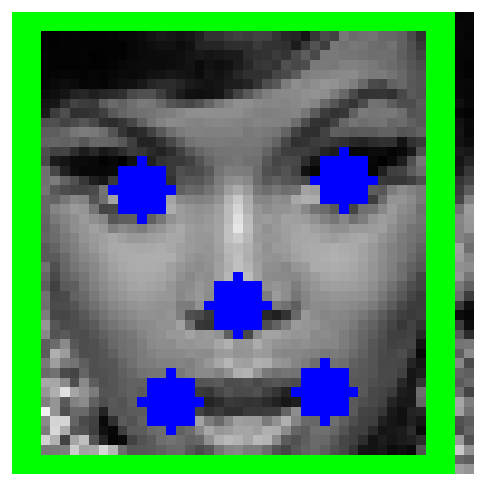

In [374]:
plt.imshow(img)
plt.axis("off")
plt.show()

it seems the picture of the woman which wasn't recognized by the haarscascade is recognized by the MTCNN Architecture 

In [ ]:
def rotate_and_crop(img, box, keypoints, eye_target_y=40, out_size=(112,112)):
    (x, y, w, h) = box
    left_eye  = keypoints["left_eye"]
    right_eye = keypoints["right_eye"]
    dy = right_eye[1] - left_eye[1]
    dx = right_eye[0] - left_eye[0]
    angle = math.degrees(math.atan2(dy, dx))
    center = (x + w//2, y + h//2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    pad = int(0.25 * max(w, h))
    x1 = max(0, x - pad); y1 = max(0, y - pad)
    x2 = min(rotated.shape[1], x + w + pad); y2 = min(rotated.shape[0], y + h + pad)
    crop = rotated[y1:y2, x1:x2]
    if crop.size == 0:
        return None
    return cv2.resize(crop, out_size, interpolation=cv2.INTER_AREA)

In [ ]:
in_dir  = Path(r"D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\data\train")   
out_dir = Path(r"D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\mtcnn\train")
out_dir.mkdir(parents=True, exist_ok=True)

detector = MTCNN()
img_exts = {".jpg"}

count = 0
for p in in_dir.rglob("*"):
    if p not in img_exts:
        continue

    bgr = cv2.imread(str(p))
    if bgr is None:
        continue
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    detections = detector.detect_faces(rgb)
    for i, det in enumerate(detections):
        crop = rotate_and_crop(bgr, det["box"], det["keypoints"])
        if crop is None:
            continue
        rel_path = p.relative_to(in_dir)  
        out_subdir = out_dir / rel_path.parent  
        out_subdir.mkdir(parents=True, exist_ok=True)

        out_path = out_subdir / f"{p.stem}_face{i}.jpg"
        cv2.imwrite(str(out_path), crop)
        count += 1


print(f"Saved {count} aligned face crop(s) to: {out_dir}")


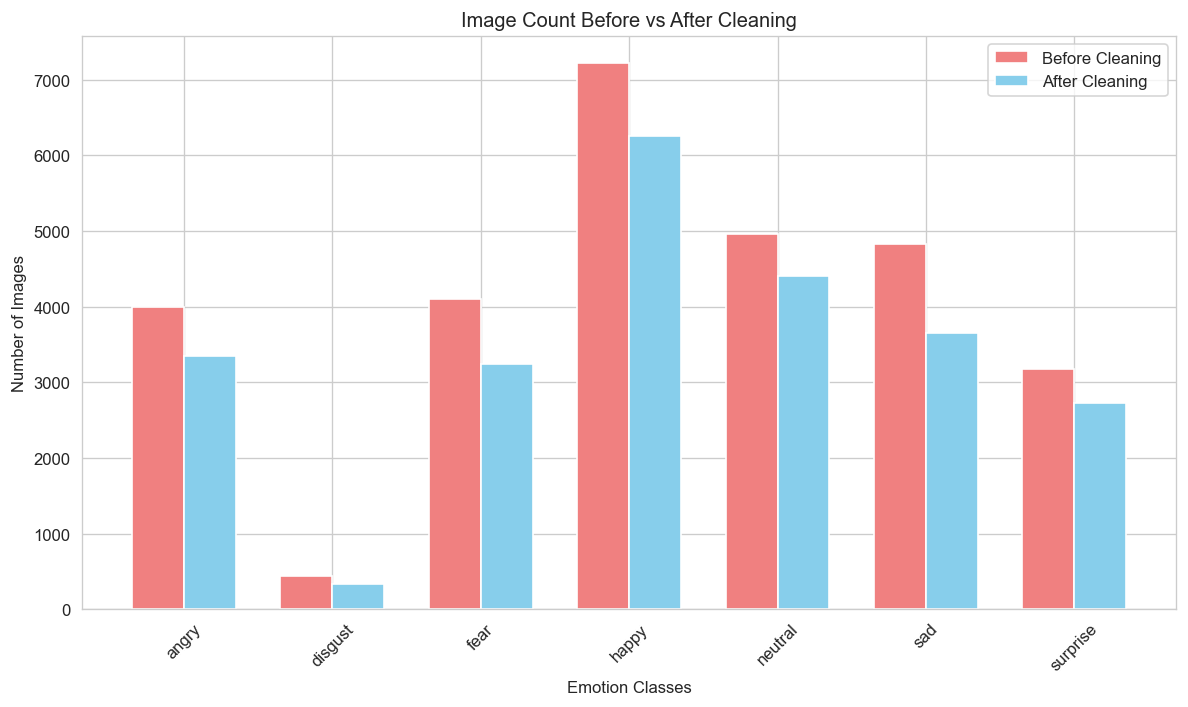

In [360]:
import os
import matplotlib.pyplot as plt
import numpy as np

# --- Define base paths ---
before_path = r"D:\University\Massey University\2nd year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\data\train"
after_path  = r"D:\University\Massey University\2nd year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\mtcnn\train"

def count_images(base_path):
    folder_counts = {}
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        if os.path.isdir(folder_path):
            count = len([
                f for f in os.listdir(folder_path)
                if os.path.isfile(os.path.join(folder_path, f))
            ])
            folder_counts[folder] = count
    return folder_counts

# --- Count images before and after cleaning ---
before_counts = count_images(before_path)
after_counts  = count_images(after_path)

# --- Ensure both have the same folder order ---
all_classes = sorted(set(before_counts.keys()) | set(after_counts.keys()))
before_values = [before_counts.get(c, 0) for c in all_classes]
after_values  = [after_counts.get(c, 0) for c in all_classes]

# --- Create double bar chart ---
x = np.arange(len(all_classes))  # positions
width = 0.35  # bar width

plt.figure(figsize=(10,6))
plt.bar(x - width/2, before_values, width, label='Before Cleaning', color='lightcoral')
plt.bar(x + width/2, after_values,  width, label='After Cleaning', color='skyblue')

plt.xlabel("Emotion Classes")
plt.ylabel("Number of Images")
plt.title("Image Count Before vs After Cleaning")
plt.xticks(x, all_classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

A lot less data are delted with use of MTCNN architecture to filter data

In [ ]:
in_dir  = Path(r"D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\data\test")   # << change this
out_dir = Path(r"D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\mtcnn\test")
out_dir.mkdir(parents=True, exist_ok=True)

count = 0
for p in in_dir.rglob("*"):
    if p not in img_exts:
        continue

    bgr = cv2.imread(str(p))
    if bgr is None:
        continue
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    detections = detector.detect_faces(rgb)
    for i, det in enumerate(detections):
        crop = rotate_and_crop(bgr, det["box"], det["keypoints"])
        if crop is None:
            continue

        rel_path = p.relative_to(in_dir)  
        out_subdir = out_dir / rel_path.parent  
        out_subdir.mkdir(parents=True, exist_ok=True)

        out_path = out_subdir / f"{p.stem}_face{i}.jpg"
        cv2.imwrite(str(out_path), crop)
        count += 1

print(f"Saved {count} aligned face crop(s) to: {out_dir}")


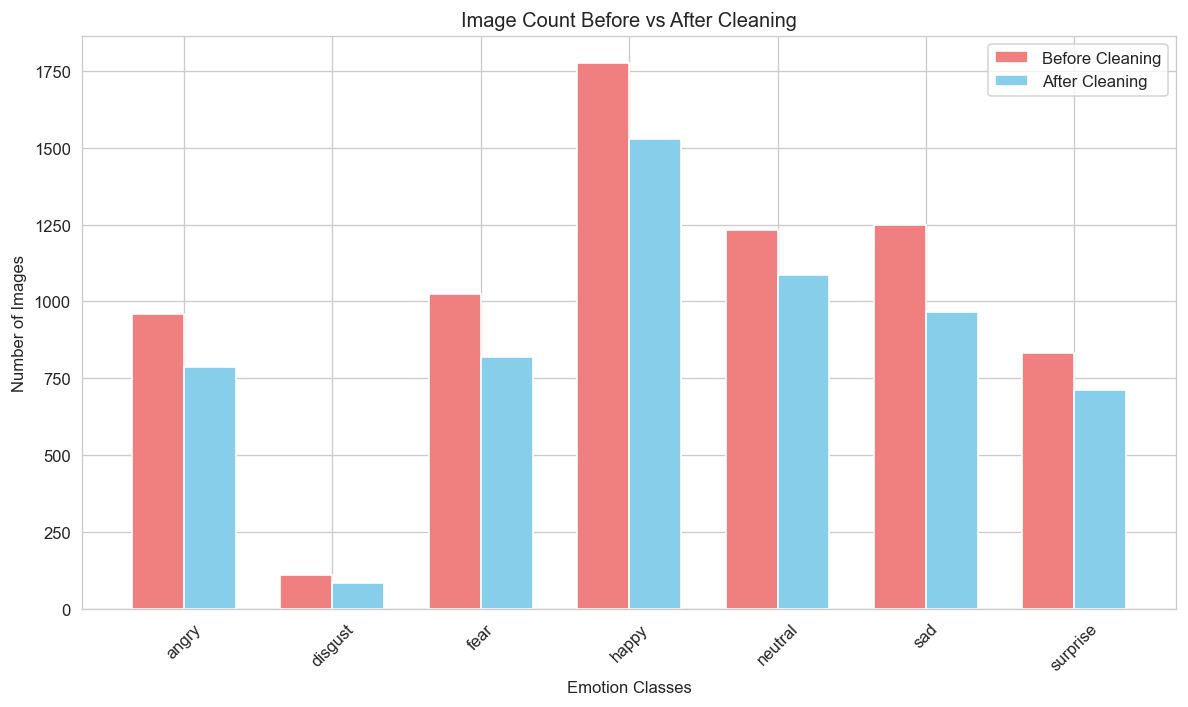

In [362]:
import os
import matplotlib.pyplot as plt
import numpy as np

# --- Define base paths ---
before_path = r"D:\University\Massey University\2nd year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\data\test"
after_path  = r"D:\University\Massey University\2nd year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\mtcnn\test"

def count_images(base_path):
    folder_counts = {}
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        if os.path.isdir(folder_path):
            count = len([
                f for f in os.listdir(folder_path)
                if os.path.isfile(os.path.join(folder_path, f))
            ])
            folder_counts[folder] = count
    return folder_counts

# --- Count images before and after cleaning ---
before_counts = count_images(before_path)
after_counts  = count_images(after_path)

# --- Ensure both have the same folder order ---
all_classes = sorted(set(before_counts.keys()) | set(after_counts.keys()))
before_values = [before_counts.get(c, 0) for c in all_classes]
after_values  = [after_counts.get(c, 0) for c in all_classes]

# --- Create double bar chart ---
x = np.arange(len(all_classes))  # positions
width = 0.35  # bar width

plt.figure(figsize=(10,6))
plt.bar(x - width/2, before_values, width, label='Before Cleaning', color='lightcoral')
plt.bar(x + width/2, after_values,  width, label='After Cleaning', color='skyblue')

plt.xlabel("Emotion Classes")
plt.ylabel("Number of Images")
plt.title("Image Count Before vs After Cleaning")
plt.xticks(x, all_classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Implementing a Random Forest Model on the Data

Wavelet transformation will be used for feature extraction

In [61]:
def to_uint8(im):
    im = im.astype(np.float32)
    im -= im.min()
    if im.max() > 0:
        im /= im.max()
    return (im * 255).astype(np.uint8)

In [90]:
def resize_to_w(img, width):
    scale = width / img.shape[1]
    return cv2.resize(img, (width, int(img.shape[0]*scale)), interpolation=cv2.INTER_AREA)

In [92]:
import pywt


def wavelet_vstack(image_bgr, wavelet="db2", level=1):
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    cA, (cH, cV, cD) = pywt.dwt2(gray, wavelet=wavelet)
    cA_v = to_uint8(cA)
    cH_v = to_uint8(np.abs(cH))
    cV_v = to_uint8(np.abs(cV))
    cD_v = to_uint8(np.abs(cD))
    h, w = gray.shape
    cA_v = resize_to_w(cA_v,w)
    cH_v = resize_to_w(cH_v,w)
    cV_v = resize_to_w(cV_v,w)
    cD_v = resize_to_w(cD_v,w)
    orig = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    cA_c = cv2.cvtColor(cA_v, cv2.COLOR_GRAY2BGR)
    cH_c = cv2.cvtColor(cH_v, cv2.COLOR_GRAY2BGR)
    cV_c = cv2.cvtColor(cV_v, cv2.COLOR_GRAY2BGR)
    cD_c = cv2.cvtColor(cD_v, cv2.COLOR_GRAY2BGR)

    vs = np.vstack([orig, cA_c, cH_c, cV_c, cD_c])
    return vs





In [94]:
in_dir  = Path(r"D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\mtcnn\train")
out_dir = Path(r"D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\wave\train")
out_dir.mkdir(parents=True, exist_ok=True)
valid_exts = {".jpg"}
for p in in_dir.rglob("*"):
    if p.suffix.lower() in valid_exts:
        img = cv2.imread(str(p))
        if img is None: 
            continue
        rel_path = p.relative_to(in_dir)
        save_folder = out_dir / rel_path.parent
        save_folder.mkdir(parents=True, exist_ok=True)
        stacked = wavelet_vstack(img, wavelet="db2", level=1)
        out_path = save_folder / f"{p.stem}_wavelet_stack.jpg"
        cv2.imwrite(str(out_path), stacked)

print("Saved vertical stacks to:", out_dir)

Saved vertical stacks to: D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\wave\train


In [95]:

in_dir  = Path(r"D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\mtcnn\test")
out_dir = Path(r"D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\wave\test")
out_dir.mkdir(parents=True, exist_ok=True)

valid_exts = {".jpg"}

for p in in_dir.rglob("*"):
    if p.suffix.lower() in valid_exts:
        img = cv2.imread(str(p))
        if img is None: 
            continue
        rel_path = p.relative_to(in_dir)
        save_folder = out_dir / rel_path.parent
        save_folder.mkdir(parents=True, exist_ok=True)

        stacked = wavelet_vstack(img, wavelet="db2", level=1)
        out_path = save_folder / f"{p.stem}_wavelet_stack.jpg"
        cv2.imwrite(str(out_path), stacked)

print("Saved vertical stacks to:", out_dir)


Saved vertical stacks to: D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\wave\test


In [96]:

def extract_wavelet_features(img_path, wavelet="db2", level=1):
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = cv2.resize(img, (64,64))
    coeffs = pywt.wavedec2(img, wavelet=wavelet, level=level)
    cA, detail_coeffs = coeffs[0], coeffs[1:]  
    features = [cA.flatten()]
    for (cH, cV, cD) in detail_coeffs:
        features.extend([cH.flatten(), cV.flatten(), cD.flatten()])
    return np.concatenate(features) 


In [97]:

data_dir = Path(r"D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\wave\train")

X, y = [], []
for folder in data_dir.iterdir():
    if folder.is_dir():
        label = folder.name
        for img_path in folder.glob("*.jpg"):
            feats = extract_wavelet_features(img_path)
            if feats is not None:
                X.append(feats)
                y.append(label)

X = np.array(X)
y = np.array(y)

print("Feature matrix:", X.shape, "Labels:", y.shape)


Feature matrix: (20096, 4356) Labels: (20096,)


In [98]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
print("Random Forest Results:\n", classification_report(y_test, rf.predict(X_test)))


Random Forest Results:
               precision    recall  f1-score   support

       angry       0.56      0.19      0.29       564
        fear       0.65      0.17      0.27       540
       happy       0.46      0.89      0.61      1075
     neutral       0.40      0.57      0.47       777
         sad       0.50      0.12      0.20       569
    surprise       0.73      0.55      0.63       495

    accuracy                           0.48      4020
   macro avg       0.55      0.42      0.41      4020
weighted avg       0.53      0.48      0.43      4020



# Implementing a Base Line CNN Architecture on the Data Set

Implementing a Baseline CNN Model 

In [315]:
import tensorflow as tf
train_ds = tf.keras.utils.image_dataset_from_directory(
    "mtcnn/train",        
    image_size=(48, 48),   
    batch_size=32,
    label_mode = "categorical"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "mtcnn/test",       
    image_size=(48, 48),
    batch_size=32,
    label_mode = "categorical"
)


Found 23952 files belonging to 7 classes.
Found 5986 files belonging to 7 classes.


Implementing a Baseline CNN Model 

In [318]:
class_names = train_ds.class_names
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))


In [320]:
from tensorflow.keras import layers, models

num_classes = len(class_names)
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(48,48,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")])

model.summary()


C:\Users\hp\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 46, 46, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 356,423 (1.36 MB)

 Trainable params: 356,423 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [322]:
model.compile(optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"])


In [324]:
history = model.fit(train_ds,validation_data=test_ds,epochs=20)


Epoch 1/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 57s 73ms/step - accuracy: 0.3211 - loss: 1.6936 - val_accuracy: 0.4407 - val_loss: 1.4577
Epoch 2/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.4476 - loss: 1.4423 - val_accuracy: 0.4714 - val_loss: 1.3397
Epoch 3/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.4895 - loss: 1.3281 - val_accuracy: 0.5184 - val_loss: 1.2520
Epoch 4/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5219 - loss: 1.2614 - val_accuracy: 0.5210 - val_loss: 1.2475
Epoch 5/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.5426 - loss: 1.2099 - val_accuracy: 0.5429 - val_loss: 1.1881
Epoch 6/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.5612 - loss: 1.1569 - val_accuracy: 0.5536 - val_loss: 1.1642
Epoch 7/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.5739 - loss: 1.1178 - val_accuracy: 0.5610 - val_loss: 1.1512
Epoch 8/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.5887 - loss: 1.0833 - 

In [325]:
loss, acc = model.evaluate(test_ds)
print(f"Test accuracy: {acc:.2f}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5780 - loss: 1.4657
Test accuracy: 0.58


In [176]:
from tensorflow.keras.preprocessing import image
x = image.img_to_array(img) / 255.0
x = np.expand_dims(x, axis=0)
pred = model.predict(x)
class_id = np.argmax(pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


In [331]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

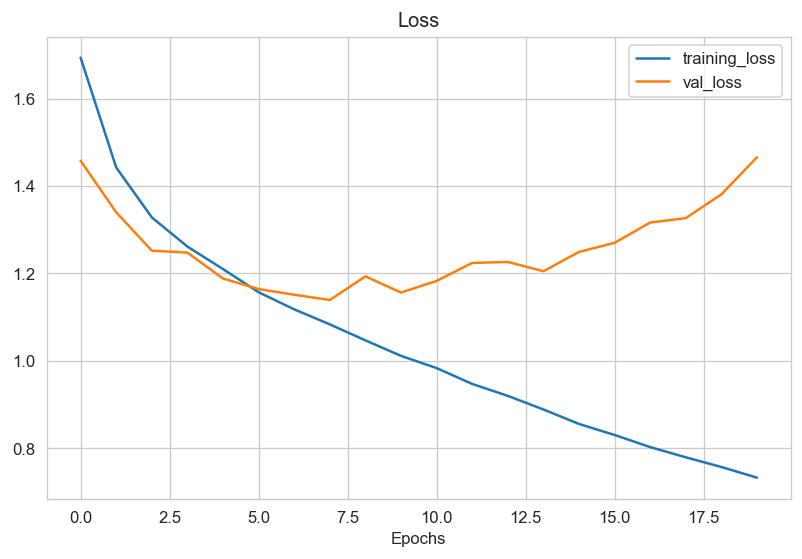

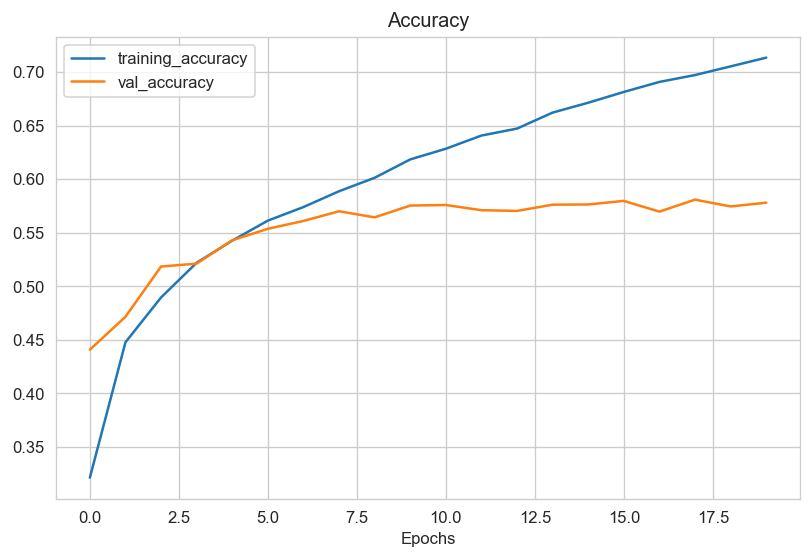

In [339]:
# Check out the loss curves of model_4
plot_loss_curves(history)
plt.show()

it seems the baseline model is overfitting the data as the validation accuracy is flattening out after the fifth epoch

# Using the Mini-xception CNN Architectire Extracted from Git Hub

In [341]:
import tensorflow as tf

img_size = (112, 112)
batch_size = 64

train_ds = tf.keras.utils.image_dataset_from_directory("mtcnn/train",labels="inferred",label_mode="categorical",   color_mode="grayscale",     
    image_size=img_size,batch_size=batch_size,shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory("mtcnn/test", labels="inferred",label_mode="categorical",color_mode="grayscale",
    image_size=img_size,batch_size=batch_size,shuffle=False)





Found 23952 files belonging to 7 classes.
Found 5986 files belonging to 7 classes.


In [342]:
def scale_pixels(x, y):
    return tf.cast(x, tf.float32) / 255.0, y



In [343]:
train_ds = train_ds.map(scale_pixels).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.map(scale_pixels).prefetch(tf.data.AUTOTUNE)

this function was extracted from Git Hub

In [345]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation,
                                     SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D)
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
def build_minixception(input_shape, num_classes, l2_reg=0.01):
    """Function for instantiating an Mini-Xception model.

    # Arguments
        input_shape: List corresponding to the input shape
            of the model.
        num_classes: Integer.
        l2_reg. Float. L2 regularization used
            in the convolutional kernels.

    # Returns
        Tensorflow-Keras model.
    """

    regularization = l2(l2_reg)

    # base
    img_input = Input(input_shape)
    x = Conv2D(5, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(16, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(128, (1, 1), strides=(1, 1),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3), padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax', name='predictions')(x)

    model = Model(img_input, output)
    return model


In [350]:
model = build_minixception(input_shape=(48, 48, 3),  num_classes=7)

In [352]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",   
    metrics=["accuracy"]
)


In [354]:

img_size = (48, 48)   
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "mtcnn/train",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"   
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "mtcnn/test",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 23952 files belonging to 7 classes.
Found 5986 files belonging to 7 classes.
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [356]:
history_2 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20
)


Epoch 1/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 50s 55ms/step - accuracy: 0.4039 - loss: 1.7309 - val_accuracy: 0.4206 - val_loss: 1.6391
Epoch 2/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 43s 58ms/step - accuracy: 0.5024 - loss: 1.4449 - val_accuracy: 0.4253 - val_loss: 1.5980
Epoch 3/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 43s 57ms/step - accuracy: 0.5353 - loss: 1.3379 - val_accuracy: 0.4375 - val_loss: 1.6444
Epoch 4/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 45s 59ms/step - accuracy: 0.5562 - loss: 1.2725 - val_accuracy: 0.4978 - val_loss: 1.4502
Epoch 5/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 45s 60ms/step - accuracy: 0.5731 - loss: 1.2238 - val_accuracy: 0.4069 - val_loss: 2.1615
Epoch 6/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 47s 63ms/step - accuracy: 0.5833 - loss: 1.1911 - val_accuracy: 0.4303 - val_loss: 1.8481
Epoch 7/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 47s 62ms/step - accuracy: 0.6005 - loss: 1.1558 - val_accuracy: 0.4611 - val_loss: 1.8179
Epoch 8/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 47s 63ms/step - accuracy: 0.6077 - loss: 1.1327 - 

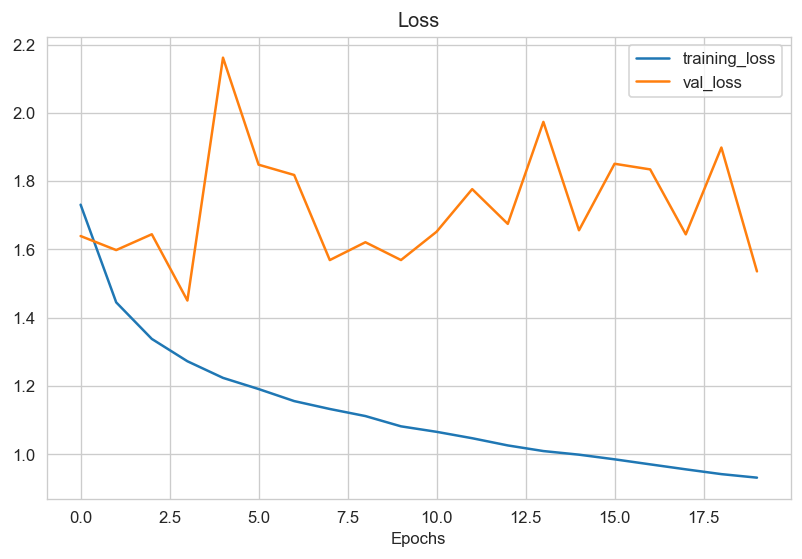

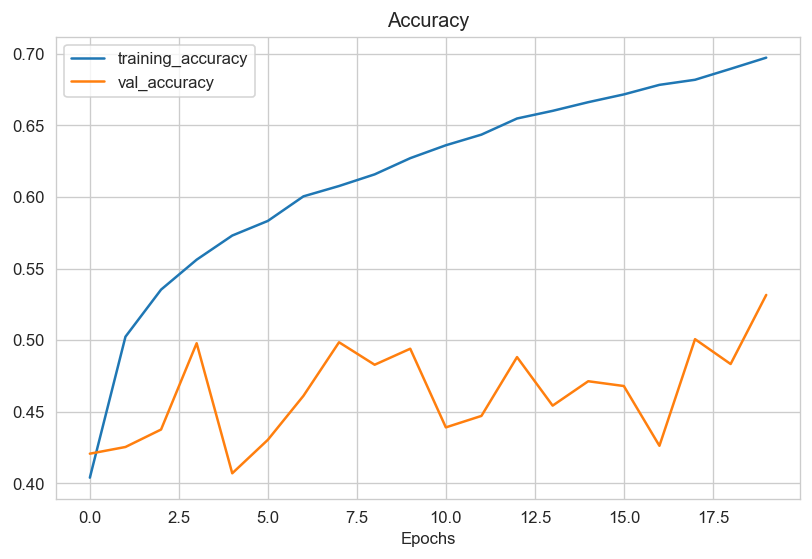

In [358]:
plot_loss_curves(history_2)
plt.show()

# Training convnext_tiny.fb_in22k

In [190]:
import random, time, math
from collections import Counter
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler

from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image

import timm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["figure.dpi"] = 120
sns.set_style("whitegrid")
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


C:\Users\hp\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


In [228]:
DATA_DIR = Path(r"D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\mtcnn")

TRAIN_DIR = DATA_DIR / "train"
TEST_DIR  = DATA_DIR / "test"

In [230]:
IMG_SIZE = 224
mean, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(12),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])



In [232]:
valid_exts = {".jpg"}
def is_image_file(path: str) -> bool:
    return Path(path).suffix.lower() in valid_exts

In [234]:
train_ds = ImageFolder(TRAIN_DIR, transform=train_tfm, is_valid_file=is_image_file)
test_ds  = ImageFolder(TEST_DIR,  transform=test_tfm,  is_valid_file=is_image_file)

In [236]:
CLASSES = train_ds.classes
NUM_CLASSES = len(CLASSES)

In [238]:
labels = np.array(train_ds.targets)
counts = np.array([np.sum(labels == i) for i in range(NUM_CLASSES)], dtype=np.float32)
print("Per-class counts:", dict(zip(CLASSES, counts.astype(int))))


Per-class counts: {'angry': np.int64(3351), 'disgust': np.int64(327), 'fear': np.int64(3244), 'happy': np.int64(6249), 'neutral': np.int64(4407), 'sad': np.int64(3653), 'surprise': np.int64(2721)}


In [240]:
weights = counts.sum() / (counts * NUM_CLASSES)
class_weights = torch.tensor(weights, dtype=torch.float32)
print("Class weights:", dict(zip(CLASSES, weights.round(3))))

Class weights: {'angry': np.float32(1.021), 'disgust': np.float32(10.464), 'fear': np.float32(1.055), 'happy': np.float32(0.548), 'neutral': np.float32(0.776), 'sad': np.float32(0.937), 'surprise': np.float32(1.258)}


In [242]:

BATCH_SIZE   = 64
NUM_WORKERS  = 2
sample_w = weights[labels]
sampler = WeightedRandomSampler(sample_w, num_samples=len(sample_w), replacement=True)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=True)

In [244]:

test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)

In [246]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [220]:
pip install hf_xet

   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
    --------------------------------------- 0.0/2.8 MB 487.6 kB/s eta 0:00:06
   --- ------------------------------------ 0.3/2.8 MB 2.4 MB/s eta 0:00:02
   ---------------------- ----------------- 1.6/2.8 MB 9.9 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 13.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [248]:
BACKBONE = "convnext_tiny.fb_in22k"  
model = timm.create_model(BACKBONE, pretrained=True, num_classes=NUM_CLASSES)
model.to("cpu")

BASE_LR = 3e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=3e-6)

scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == "cpu"))

C:\Users\hp\AppData\Local\Temp\ipykernel_19012\2257263815.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == "cpu"))


In [250]:
def accuracy_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()

In [252]:
def train_one_epoch(model, loader, criterion):
    model.train()
    total_loss, total_acc, total_n = 0.0, 0.0, 0

    pbar = tqdm(loader, leave=False, desc="train")
    for x, y in pbar:
        x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
            logits = model(x)
            loss   = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        acc = accuracy_from_logits(logits, y)
        bs  = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += acc * bs
        total_n    += bs

        pbar.set_postfix(loss=f"{total_loss/total_n:.3f}", acc=f"{total_acc/total_n:.3f}")

    return total_loss/total_n, total_acc/total_n

In [254]:
@torch.no_grad()
def eval_one_epoch(model, loader, criterion):
    model.eval()
    total_loss, total_acc, total_n = 0.0, 0.0, 0
    pbar = tqdm(loader, leave=False, desc="val  ")
    for x, y in pbar:
        x, y   = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
        logits = model(x)
        loss   = criterion(logits, y)
        acc = accuracy_from_logits(logits, y)
        bs  = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += acc * bs
        total_n    += bs
        pbar.set_postfix(loss=f"{total_loss/total_n:.3f}", acc=f"{total_acc/total_n:.3f}")
    return total_loss/total_n, total_acc/total_n

In [256]:
EPOCHS   = 20
PATIENCE = 5
best_val_acc = -1.0
wait = 0
history = []
print(f"Training on {DEVICE} for {EPOCHS} epochs …")
for ep in range(1, EPOCHS + 1):
    t0 = time.time()
    tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion)
    va_loss, va_acc = eval_one_epoch(model,  test_loader,  criterion)  
    scheduler.step()
    history.append({"ep": ep, "tr_loss": tr_loss, "tr_acc": tr_acc,
                    "va_loss": va_loss, "va_acc": va_acc})
    print(f"Ep {ep:02d} | train {tr_loss:.3f}/{tr_acc:.3f} "
          f"| val {va_loss:.3f}/{va_acc:.3f} | time {time.time()-t0:.1f}s")
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        wait = 0
        torch.save({"model": model.state_dict(), "classes": CLASSES}, "best_model.pt")
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping.")
            break

print("Best val acc:", best_val_acc)

Training on cpu for 20 epochs …


C:\Users\hp\miniconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\hp\AppData\Local\Temp\ipykernel_19012\3175490322.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
                                                                                                                       

Ep 01 | train 0.712/0.476 | val 1.197/0.568 | time 6385.8s


Ep 02 | train 0.404/0.669 | val 1.060/0.619 | time 6297.1s


Ep 03 | train 0.331/0.716 | val 0.976/0.659 | time 6417.7s


Ep 04 | train 0.232/0.803 | val 1.116/0.636 | time 6129.6s


Ep 05 | train 0.210/0.828 | val 1.044/0.664 | time 6082.2s


Ep 06 | train 0.150/0.878 | val 1.091/0.670 | time 6009.2s


Ep 07 | train 0.118/0.903 | val 1.181/0.649 | time 5773.1s


Ep 08 | train 0.126/0.897 | val 1.145/0.687 | time 5677.2s


Ep 09 | train 0.072/0.944 | val 1.239/0.668 | time 5633.5s


Ep 10 | train 0.051/0.958 | val 1.311/0.695 | time 5785.6s


IOPub message rate exceeded.                                 | 46/375 [11:20<1:18:42, 14.35s/it, acc=0.968, loss=0.045]
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

                                                                                                                       

Ep 12 | train 0.040/0.970 | val 1.394/0.684 | time 6099.3s


Ep 13 | train 0.030/0.975 | val 1.516/0.676 | time 6377.1s


Ep 14 | train 0.052/0.958 | val 1.396/0.695 | time 6113.2s


Ep 15 | train 0.022/0.983 | val 1.536/0.698 | time 5932.3s


Ep 16 | train 0.016/0.987 | val 1.610/0.701 | time 6109.4s


Ep 17 | train 0.014/0.989 | val 1.628/0.705 | time 6039.5s


Ep 18 | train 0.012/0.991 | val 1.652/0.702 | time 5864.6s


Ep 19 | train 0.011/0.991 | val 1.737/0.699 | time 6120.0s


Ep 20 | train 0.011/0.992 | val 1.693/0.702 | time 6947.3s
Best val acc: 0.704811226234283


In [364]:
ckpt = torch.load("best_model.pt", map_location=DEVICE)
model.eval()


AttributeError: 'Functional' object has no attribute 'eval'

In [366]:

all_preds, all_true = [], []
with torch.no_grad():
    for x, y in tqdm(test_loader, leave=False):
        x = x.to(DEVICE, non_blocking=True)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.append(preds)
        all_true.append(y.numpy())

all_preds = np.concatenate(all_preds)
all_true  = np.concatenate(all_true)

print("TEST RESULTS")
print(classification_report(all_true, all_preds, target_names=CLASSES, digits=2))


C:\Users\hp\miniconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                                                                                                                       

ValueError: Input 0 of layer "functional_5" is incompatible with the layer: expected shape=(None, 48, 48, 3), found shape=torch.Size([64, 3, 224, 224])

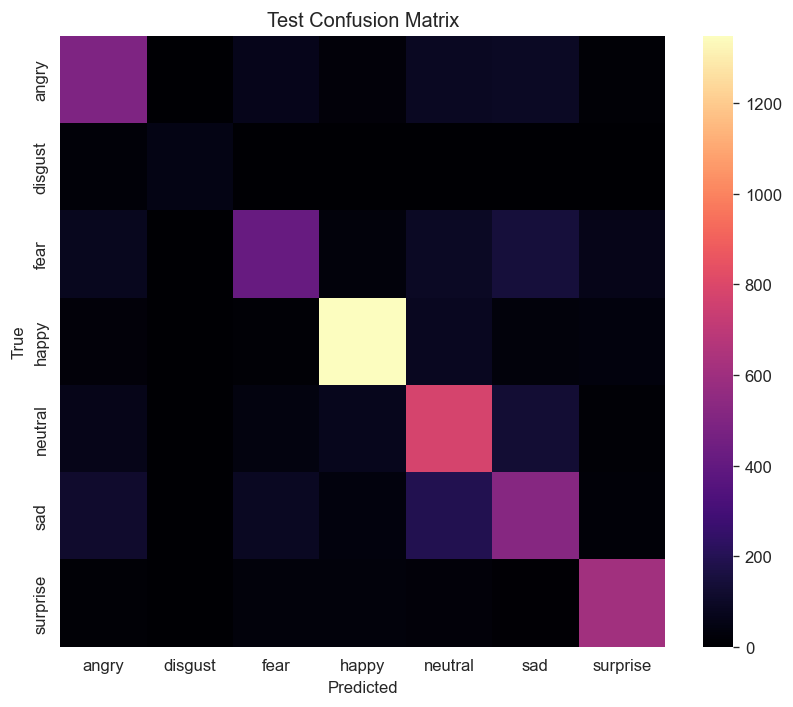

In [275]:
cm = confusion_matrix(all_true, all_preds, labels=list(range(NUM_CLASSES)))
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=False, fmt="d", cmap="magma",
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [277]:
def predict_image(img_path: str, model, transform=test_tfm, topk=3):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy().ravel()
    idxs = probs.argsort()[::-1][:topk]
    return [(CLASSES[i], float(probs[i])) for i in idxs]
